# **CLUSTERING MODELS**

This notebook consists of two objectives:

1. Perform exploratory analysis to extract meaningful insight from the data and identify the best features to be used for modeling.  

2. Train, test, and refine various clustering models in order to create more explainable people groups. The predictive algorithms to be trained are:
    - K Means
    - Hierarchical
    - DBSCAN
    - HDBSCAN
    - GMM (Gaussian Mixture Models)

### **TRAINING DATA PRE-PROCESSING** 
The first step in the machine learning pipeline is to clean and transform the training data into a useable format for analysis and modeling.   

As such, data pre-processing addresses:
- Assumptions about data shape
- Incorrect data types
- Outliers or errors
- Missing values
- Categorical variables 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

In [2]:
# Read data
train_data = pd.read_csv('../data/data.csv')

**Data Shape**

After loading the dataset, I examine its shape to get a better sense of the data and the information it contains.  

In [3]:
# Data shape
print('train data:',train_data.shape)

train data: (8957, 363)


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_rows', 1000)
pd.set_option('display.width', None)

In [5]:
# View first few rows
train_data.head()

,pseudo_id,today,interviewtype,monitor_gender,interview_province,interview_district,site_001,site_type,assessment_modality,are_you_headhh,respondent_gender,status,province,district,head_age_group,marital_status,widow_o_martyrdom_certi_cate,what_is_your_occupation_what_i,what_is_sizeyour_famil,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,have_children,have_children_001,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,do_you_have_difficul_you_have_1,do_you_have_difficul_using_a__1,do_you_have_difficul_ngclimbi_1,do_you_have_difficul_ingconce_1,do_you_have_difficul_all_verd_1,using_your_usual_cubeing_unde_1,do_you_your_family_m_rotectio_1,psychological_distress,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,children_behaviour,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,oth_members_behaviour,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,health_facility,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,access_health_facility_no,psychological_support,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,access_mhpss_facility_no_001,are_you_currently_receiving_fo,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,wash_access,access_water,do_all_hh_members_h,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,legal_aid_access,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,access_legal,been_able_t_xternal_interference,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,engageexploitative_act,yes_who_boys,yes_wh

In [6]:
# Data Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Columns: 363 entries, pseudo_id to weight
dtypes: float64(300), int64(1), object(62)
memory usage: 24.8+ MB


**Missing Data**

From the entry totals above, there appears to be missing data.  A heatmap will help better visualize what features as missing the most information.

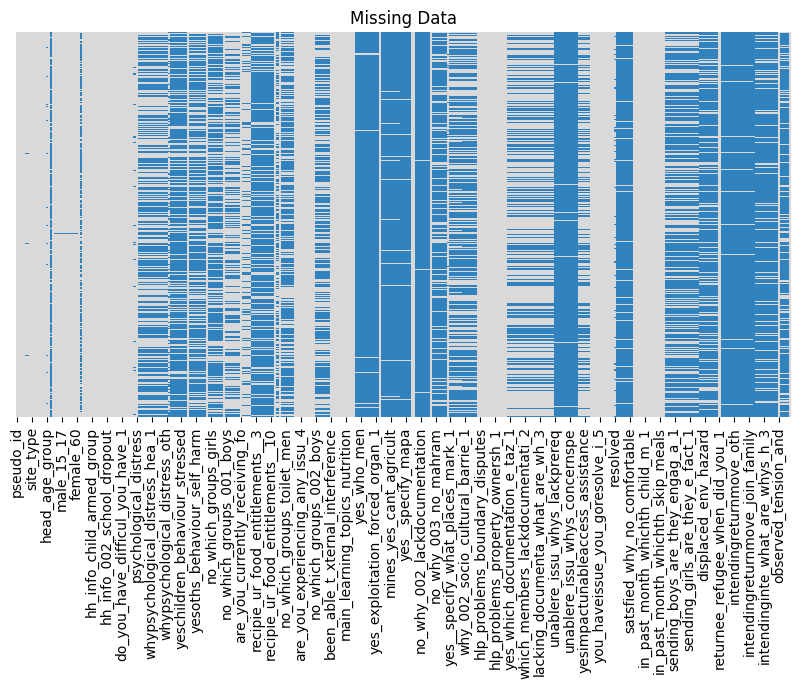

In [8]:
# Heatmap
sns.heatmap(train_data.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

A lot of columns are full of missing data. But we can't drop most of this columns. This is because this missing data is a meaningful state.

For example, for the column whypsychological_distress_oth:

| Value   | Meaning                                      | Cases    |
| ------- | -------------------------------------------- | -------- |
| 1       | 0 (No)                                       | 4341     |
| 2       | 1 (Yes)                                      | 179      |
| Missing | *(Not asked / Not applicable / No distress)* | **4437** |

In surveys like this:
Missing often means “the question did not apply to the respondent.”

So we can't just drop this kind of columns because we would lose important values.


Besides this, there are some columns that are not useful for model trining. They don't provide any interesting information for us.
- id
- today
- interviewtype
- monitor_gender
- interview_province
- interview_district
- site_001
- assessment_modality

# Categorical Features

In [9]:
print('Non-Null Objects to Be Converted to Category')
print(train_data.select_dtypes(['object']).columns)

Non-Null Objects to Be Converted to Category
Index(['today', 'interviewtype', 'monitor_gender', 'interview_province',
       'interview_district', 'site_001', 'site_type', 'assessment_modality',
       'are_you_headhh', 'respondent_gender', 'status', 'province', 'district',
       'head_age_group', 'marital_status', 'widow_o_martyrdom_certi_cate',
       'what_is_your_occupation_what_i', 'what_is_sizeyour_famil',
       'have_children', 'have_children_001', 'do_you_have_difficul_you_have_1',
       'do_you_have_difficul_using_a__1', 'do_you_have_difficul_ngclimbi_1',
       'do_you_have_difficul_ingconce_1', 'do_you_have_difficul_all_verd_1',
       'using_your_usual_cubeing_unde_1', 'do_you_your_family_m_rotectio_1',
       'psychological_distress', 'children_behaviour', 'oth_members_behaviour',
       'health_facility', 'access_health_facility_no', 'psychological_support',
       'access_mhpss_facility_no_001', 'are_you_currently_receiving_fo',
       'wash_access', 'access_water', '

# Searching relations between different parameters

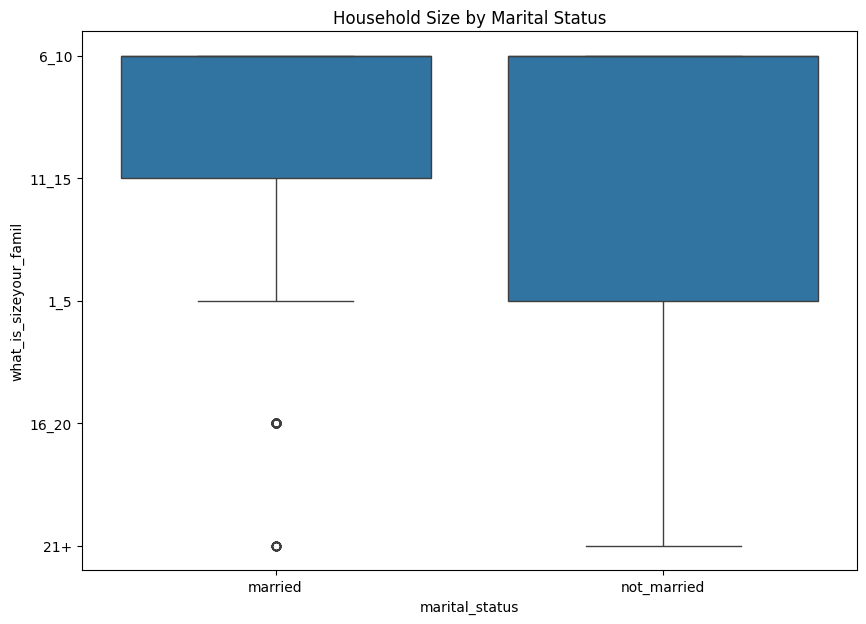

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(
    x='marital_status',
    y='what_is_sizeyour_famil',
    data=train_data
).set_title('Household Size by Marital Status')
plt.show()

While both married and non-married households commonly range between 6–15 members, extremely large households (21+ members) are observed more frequently among non-married household heads. This suggests extended or dependency-heavy household structures, likely driven by displacement, widowhood, or family aggregation as a coping strategy. These households may require differentiated shelter and support approaches.

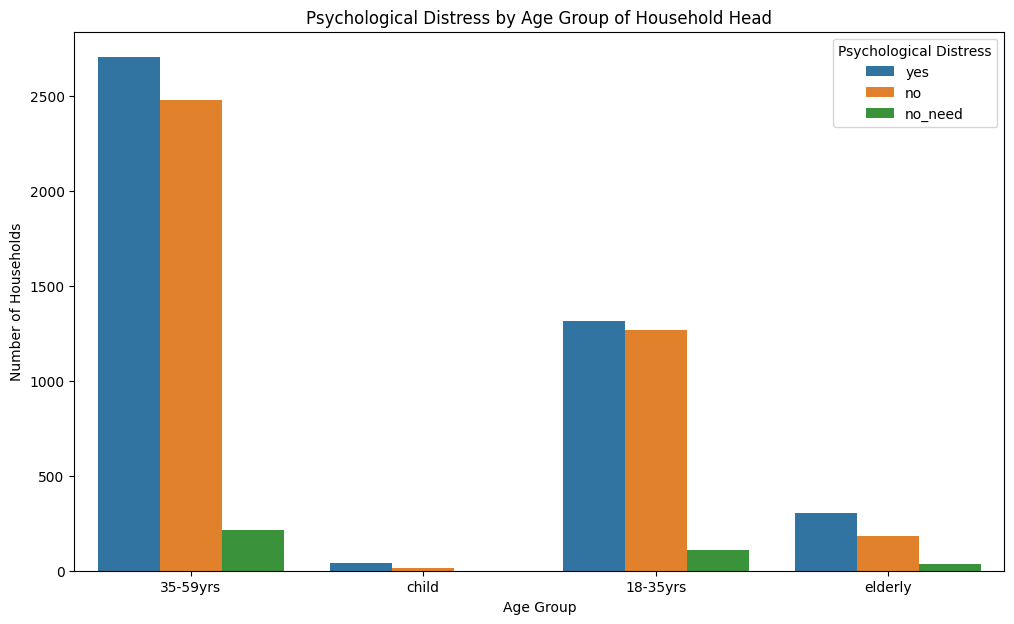

In [11]:
plt.figure(figsize=(12,7))
sns.countplot(
    x='head_age_group',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Age Group of Household Head')
plt.xlabel('Age Group')
plt.ylabel('Number of Households')
plt.legend(title='Psychological Distress')
plt.show()

Most people report needing psychological support, regardless of age.
Psychological distress is high across all age groups, and no specific age group stands out as having a significantly higher or lower level of distress.

In [12]:
plt.figure(figsize=(120,70))
sns.countplot(
    x='access_health_facility_no',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Access of health facilities')
plt.xlabel('Access of health facilities')
plt.ylabel('Psychological distress')
plt.legend(title='Psychological Distress')
plt.show()


The majority of people needs psychological help but does not have access to health facilities or the service is just not available.

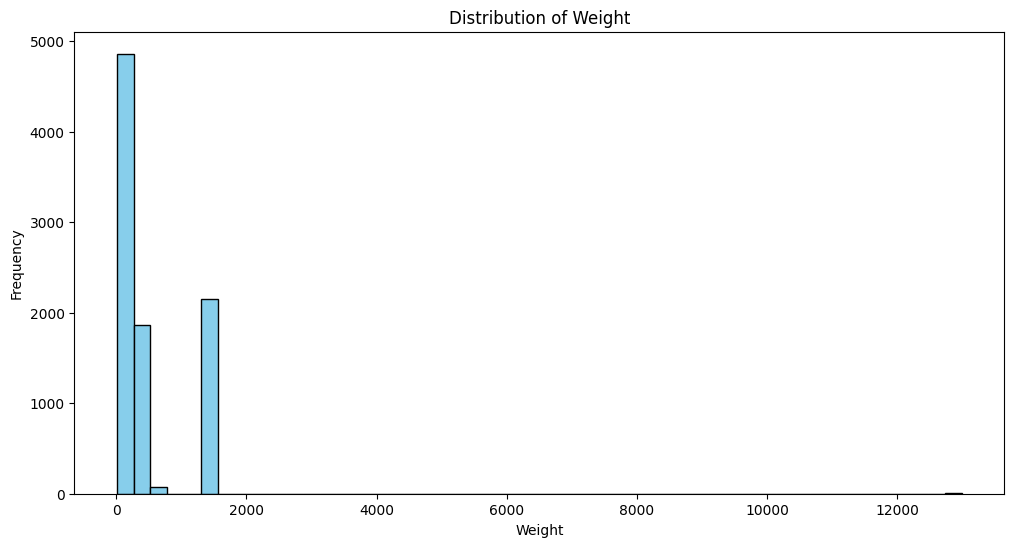

In [13]:
plt.figure(figsize=(12,6))
plt.hist(train_data['weight'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

Some weight values seem inconsistent, likely because different units of measurement were used.
This is very inconsistent, and we don't have any way to predict what the correct values would be, so we are going to drop the column.

# Preprocessing

### **Categorical Features**

In [7]:
# drop unnecessary columns
train_data = train_data.drop(columns=[
    'pseudo_id', 
    'today', 
    'interviewtype', 
    'monitor_gender', 
    'interview_province', 
    'interview_district', 
    'site_001', 
    'assessment_modality'
])

In [8]:
# Identify categorical features
objects = train_data.select_dtypes(['object']).columns

# Convert categorical variables into 'dummy' or indicator variables
for object_ in objects:
    pd.get_dummies(train_data[object_], drop_first = True)

train_data = pd.get_dummies(train_data, drop_first=True)
train_data.head(1)

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

In [9]:
# These columns must be 0 if they are not answered
count_cols = [
    'male_0_6','male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60'
]
train_data[count_cols] = train_data[count_cols].fillna(0)

# NaN to 0
float_cols = train_data.select_dtypes(include='float64').columns
train_data[float_cols] = train_data[float_cols].fillna(0.0)

In [10]:
train_data = train_data.drop(columns=['weight'])
# Weight values are so inconsistent. They use different units so we can not use them.

We will interpret NaN values as unanswered responses. This approach gives more emphasis to positive answers.

In [11]:
train_data.head()

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

>Now the data is perfect for a machine learning algorithm:  
- all the data is numeric
- everything is concatenated together

## **MACHINE LEARNING (Clustering models)**

In this section we apply multiple **unsupervised clustering** algorithms to group people with similar need profiles.  
Because our dataset has **no ground-truth labels** (we do not know the “correct” cluster for each person), we cannot evaluate performance using accuracy/precision/recall like in supervised learning. Instead, we compare clusterings by combining:

1) **Internal clustering metrics** (based only on distances within the dataset)  
2) **Practical constraints** required by our use case (usable cluster sizes, limited noise, interpretability)

We will compare the following models:

- **K-Means**
- **Hierarchical (Agglomerative Clustering)**
- **DBSCAN**
- **HDBSCAN**
- **GMM (Gaussian Mixture Models)**

> **Fair comparison rule:** all models will be trained on the same preprocessed feature matrix, and we will evaluate each model with the same scoring framework.

---

## **Performance evaluation (why it’s different in clustering)**

Evaluating clustering is not as straightforward as counting “errors”. In clustering, the numeric label values (0, 1, 2, …) are arbitrary: a clustering that labels a group as “2” is not better or worse than the same group being labeled “0”.  
Therefore, evaluation focuses on whether the algorithm produced **meaningful separations** in the data: points inside a cluster should be **more similar** to each other than to points in other clusters, according to some distance/similarity notion.

Because we do **not** have ground-truth shelter assignments, we use **internal validation metrics** from scikit-learn’s documentation (i.e., metrics computed from the dataset and the clustering output itself). These metrics give us a consistent way to compare different algorithms and hyperparameters.

---

## **Internal evaluation metrics (official scikit-learn concepts)**

We use three widely supported internal metrics:

### 1) Silhouette Score (higher is better)

The **Silhouette Coefficient** measures how well-separated clusters are by comparing, for each sample:

- **a** = mean distance to other points in the **same cluster**  
- **b** = mean distance to points in the **nearest different cluster**

Intuition:
- If **a** is much smaller than **b**, the point fits well in its cluster.
- If **a ≈ b**, clusters overlap.
- If **a > b**, the point may be assigned to the wrong cluster.

**Range:** from **-1** (bad clustering) to **+1** (very well separated). Values near **0** often indicate overlapping clusters.

**Why it’s useful in our project**
- We need clusters that represent clearly distinct “profiles of needs”, so we value **separation** and **cohesion**.
- It is a strong baseline metric for checking if the clustering produces clearly defined groups.

**Limitations**
- Silhouette typically favors **convex / “round”** clusters and may underrate valid clusters produced by density-based methods (DBSCAN/HDBSCAN), especially when shapes are irregular or include noise points.

---

### 2) Calinski–Harabasz Index (higher is better)

The **Calinski–Harabasz score** (Variance Ratio Criterion) is based on the ratio:

- **between-cluster dispersion** (how far cluster centers are from each other)
vs
- **within-cluster dispersion** (how spread points are within clusters)

Intuition:
- Higher score means clusters are **compact internally** and **far apart from each other**.

**Why it’s useful in our project**
- Helps detect partitions where clusters represent strongly separated groups of people.
- It is **fast to compute**, which is practical when testing many hyperparameter configurations.

**Limitations**
- Like Silhouette, it tends to favor convex/separable clusters, and may not fully reflect the value of density-based clustering when the data has irregular shapes.

---

### 3) Davies–Bouldin Index (lower is better)

The **Davies–Bouldin index** measures the average “similarity” between each cluster and its most similar cluster, where similarity compares:

- cluster **spread** (how big / dispersed a cluster is)
vs
- cluster **separation** (distance between cluster centers)

**Best value:** **0** (theoretical minimum).  
**Lower** values indicate better cluster separation relative to cluster size.

**Why it’s useful in our project**
- Provides an additional view of compactness vs separation.
- It is simple and commonly reported in clustering comparisons.

**Limitations**
- Uses centroid-based distances, which effectively assumes **Euclidean geometry** and can penalize non-convex cluster shapes.
- Density-based methods may produce structures that are valid but less favored by centroid-based scoring.

---

## **Model-specific interpretation algorithms (short, project-oriented)**

Internal metrics (Silhouette / Calinski–Harabasz / Davies–Bouldin) help us compare clusterings, but they do not explain **what each cluster means**.  
Since our goal is to help shelter workers understand *why* a person belongs to a group, we add **simple, model-specific interpretation tools**.

### K-Means
- **Elbow method**  
  Used to narrow down a sensible range of `n_clusters` before deeper evaluation. Works because K-Means optimizes inertia.
- **Cluster prototypes (centroid / feature lift summary)**  
  For each cluster, we compute the most characteristic needs (features that are much higher than the global average). This produces interpretable “profiles”.

### Hierarchical (Agglomerative Clustering)
- **Dendrogram / linkage distance inspection**  
  Helps decide where to “cut” the tree (i.e., choose `n_clusters`) by looking for large jumps in merge distances (a natural alternative to elbow here).
- **Cluster profiles (feature lift summary)**  
  Same idea as K-Means: summarize each cluster by its top distinguishing needs.

### DBSCAN
- **k-distance plot (for choosing `eps`)**  
  We plot distances to each point’s k-th nearest neighbor (k ≈ `min_samples`) and look for a “knee”. This is the standard practical tool to pick `eps`.
- **Noise & core diagnostics**  
  We report noise ratio (`label = -1`) and cluster size distribution. For our project, too much noise usually reduces usefulness.

### HDBSCAN
- **Stability / persistence (how “strong” clusters are)**  
  HDBSCAN builds a hierarchy and selects clusters based on stability. We use stability and noise ratio as key tuning signals (`min_cluster_size`, `min_samples`).
- **Cluster profiles (feature lift summary)**  
  Same interpretability output as other models, but we also explicitly describe what “noise” represents (outlier / mixed cases).

### GMM (Gaussian Mixture Models)
- **AIC/BIC vs number of components (elbow-like selection)**  
  GMM does not optimize inertia, so we don’t use the inertia elbow. Instead we pick `n_components` using AIC/BIC curves and look for diminishing returns.
- **Soft assignment confidence (membership probabilities)**  
  GMM provides probabilities per component. For our use case, this is useful to flag **uncertain** cases (e.g., a person fits 2 profiles similarly), which can be shown to workers.

---

## **How we will use these metrics (project-aware interpretation)**

These metrics are **not a perfect “truth detector”**. They encode a particular idea of what a “good” cluster looks like (compact and separated).  
In our context, we will treat them as **comparative indicators** (helpful for ranking candidates) but **not the only decision criterion**, because:

- DBSCAN/HDBSCAN may create meaningful groups + noise points that internal metrics can penalize.
- Some solutions can “game” a metric by producing too many small clusters or overly compact clusters.

So we combine metric scores with **practical constraints** and (later) interpretability checks.

---

## **Practical constraints (requirements of this project)**

A clustering output must be usable for shelter workers. Even if a clustering has good metric scores, it is not useful if it produces unrealistic or unusable groupings.

We therefore consider these constraints alongside the scores:

- **Cluster count:** must stay in a sensible range (e.g., **4–30**)  
  - Too few clusters → profiles become too broad and unhelpful  
  - Too many clusters → output becomes hard to interpret and act on

- **Noise ratio (for DBSCAN/HDBSCAN):** should not be too high  
  - If a large percentage is labeled as noise, the method may be misconfigured or unsuitable

- **Minimum cluster size:** avoid tiny clusters  
  - Very small clusters can be unstable and hard to interpret  
  - Exception: rare-but-important cases can be acceptable if they are consistent and meaningful

- **Interpretability:** clusters must have clear “top needs” patterns  
  - We need to explain clusters in human terms (e.g., “high legal needs + unable to work”, “elderly + health-related needs”)

## Data preparation

First, we will split the data: 75% for training and 25% for testing.

In [12]:
from sklearn.model_selection import train_test_split

# Split data
train_df, test_df = train_test_split(train_data, test_size=0.25, random_state=42)
train_df.to_csv('../data/train_data.csv', index=False)
test_df.to_csv('../data/test_data.csv', index=False)

### Scaled parameters
We use scaled data (X_scaled) for **model training** because most machine learning algorithms rely on distance calculations.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df)

### Umap
We use UMAP only for **visualization purposes**, not for model training.

In [16]:
import umap

try:
    reducer = umap.UMAP(n_components=2,
                       n_neighbors=30,
                       min_dist=0.1,
                       metric='euclidean',
                       random_state=42,
                       verbose=True)
    embedding = reducer.fit_transform(X_scaled)
    train_df['umap1'] = embedding[:, 0]
    train_df['umap2'] = embedding[:, 1]
except Exception as e:
    print("Couldn't use Umap 2D:", e)
    embedding = X_scaled[:, :2]
    train_df['umap1'] = embedding[:, 0]
    train_df['umap2'] = embedding[:, 1]

UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Mon Jan 19 08:16:21 2026 Construct fuzzy simplicial set
Mon Jan 19 08:16:21 2026 Finding Nearest Neighbors
Mon Jan 19 08:16:21 2026 Building RP forest with 9 trees
Mon Jan 19 08:16:21 2026 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Mon Jan 19 08:16:25 2026 Finished Nearest Neighbor Search
Mon Jan 19 08:16:29 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 19 08:17:09 2026 Finished embedding


# **K-Means**

**K-Means** is a clustering algorithm that partitions the dataset into **clusters** by minimizing the **within-cluster sum of squares**. Each cluster is represented by its **centroid**, which is the mean of all points assigned to that cluster. In practice, the algorithm iterates between:

1) Assigning each person to the nearest centroid  
2) Updating each centroid as the mean of the assigned people until centroids stop moving significantly.

K-Means requires choosing **K (the number of clusters)** in advance. The algorithm then finds k centroids that minimize inertia (also called WCSS):

- Inertia / WCSS = sum of squared Euclidean distances from each point to its assigned centroid.
- Lower inertia means points are closer to their centroids (more compact clusters).

### **Why K-Means is useful for our project**
We include K-Means as a strong baseline because it matches several practical needs:

- **Fast and scalable:** with many features, we can still test multiple values of **K** and compare results efficiently.
- **Simple cluster representation:** each cluster has a centroid, which makes it easier to build **cluster profiles** (e.g., “this group tends to have higher legal needs and health issues”).
- **Good for “prototype” groups:** if the data naturally forms compact groups, K-Means can produce clear, well-separated clusters that are easy to explain to non-technical users.
- **Stable comparison reference:** even if another model wins, K-Means provides a consistent benchmark for evaluating whether more complex methods actually add value.

### **Limitations (important for interpretation)**
- K-Means works best when clusters are **roughly convex and similarly sized**. If people’s needs form irregular shapes or variable-density groups, density-based methods (DBSCAN/HDBSCAN) may capture structure better.
- It can converge to a **local minimum**, so it is typically run multiple times with smart initialization (e.g., **k-means++**) to improve consistency.
- In high-dimensional spaces, Euclidean distances can become less informative; therefore K-Means results should be interpreted alongside our full evaluation framework (metrics + practical constraints + interpretability).

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

dfkmean = train_df

## Elbow method

The elbow is the k where the curve changes from:

- **Steep decrease** (adding clusters significantly improves compactness)
to
- **Slow decrease** (extra clusters only reduce inertia slightly)

Interpretation:

- Before the elbow: K-Means is underfitting (clusters too coarse).

- After the elbow: gains are small; extra clusters mostly split existing groups into smaller ones.

Because K-Means directly optimizes inertia, inertia will always decrease as k increases (more centroids → better fit). Therefore, we are not looking for the minimum inertia (that would be k = n_samples), but for a point where adding more clusters yields diminishing returns.

**Important limitation:** elbow is a heuristic. In many real datasets, the curve is smooth and there is no sharp elbow. That’s why we use elbow only to restrict k to a plausible range, then validate with internal metrics + practical constraints.

### Choosing a k range

In theory, we could test any `k` from **2** up to **one cluster per person** (`k = n_samples`). However, this is not practical and it is rarely useful:

- very large `k` values reduce inertia automatically (even if clusters are not meaningful),
- they create many tiny clusters that are hard to interpret and not actionable for our project,
- and they significantly increase computation time.

Therefore, we restrict the search to a **reasonable k range** aligned with our practical constraints (interpretability and minimum cluster size). This avoids running unnecessary configurations and keeps the evaluation focused on clusterings that could realistically be used by shelter workers.

In [ ]:
n_samples = X_scaled.shape[0]

K_MIN = 2
K_MAX = int(n_samples / 10)
K_MAX = min(K_MAX, n_samples)

K_MAX = max(K_MAX, K_MIN + 1)

step = max(1, (K_MAX - K_MIN) // 40)

ks = np.arange(K_MIN, K_MAX + 1, step, dtype=int)

if ks[-1] != K_MAX:
    ks = np.append(ks, K_MAX)

In [ ]:
inertias = []

for k in ks:
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init="auto",
        random_state=42
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

inertias = np.array(inertias, dtype=float)

### Automatic knee detection

Returns index of the point with maximum perpendicular distance to the line connecting the first and last points (a common elbow heuristic).

In [ ]:
def knee_max_distance(x, y):
    x = x.astype(float)
    y = y.astype(float)

    xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
    yn = (y - y.min()) / (y.max() - y.min() + 1e-12)

    p = np.column_stack([xn, yn])
    p1, p2 = p[0], p[-1]
    line = p2 - p1
    line_norm = np.linalg.norm(line) + 1e-12
    line_unit = line / line_norm

    v = p - p1
    proj = (v @ line_unit)[:, None] * line_unit[None, :]
    perp = v - proj
    dist = np.linalg.norm(perp, axis=1)

    idx = int(np.argmax(dist))
    return idx, dist

elbow_idx, elbow_dist = knee_max_distance(ks, inertias)
k_elbow = int(ks[elbow_idx])

print(f"Elbow candidate (knee heuristic): k = {k_elbow}")

Elbow candidate (knee heuristic): k = 146


### Plot inertia + elbow

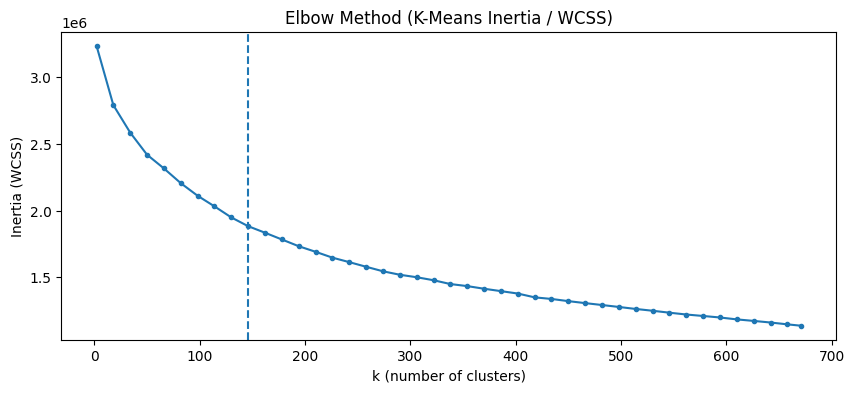

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ks, inertias, marker=".")
plt.axvline(k_elbow, linestyle="--")
plt.title("Elbow Method (K-Means Inertia / WCSS)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (WCSS)")
plt.show()

In [57]:
n_clusters = k_elbow
print("Best n_clusters for K-Means: " + str(n_clusters))

Best n_clusters for K-Means: 146


## Elbow interpretation

The elbow at 146 suggests the dataset has lots of micro-structure (many distinct patterns), and inertia keeps improving until relatively high k.

But our project requires fewer, more actionable profiles, so we must choose a smaller k using the full framework (metrics + constraints + interpretability), not inertia alone.

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune K-Means using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best K-Means configuration** (mainly the choice of `k`)
- **compare K-Means fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

In [61]:
from sklearn.metrics import silhouette_score

In [ ]:
results = []

sample_size = min(int(n_samples/3), X_scaled.shape[0])
for k in ks:
    km = KMeans(n_clusters=int(k), init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)

    score = silhouette_score(X_scaled, labels, sample_size=sample_size, random_state=42)

    results.append((score, int(k), km.inertia_))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Silhouette (higher is better):")
print("silhouette | k | inertia")
for score, k, inertia in results[:15]:
    print(f"{score:9.5f} | {k:4d} | {inertia:.3e}")

Top k by Silhouette (higher is better):
silhouette | k | inertia
  0.09306 |    2 | 3.236e+06
  0.07621 |  671 | 1.137e+06
  0.07546 |  658 | 1.148e+06
  0.07372 |  642 | 1.162e+06
  0.07319 |  610 | 1.185e+06
  0.07314 |  626 | 1.174e+06
  0.07278 |  594 | 1.199e+06
  0.07250 |  562 | 1.222e+06
  0.07201 |  578 | 1.211e+06
  0.07144 |  546 | 1.235e+06
  0.07079 |  450 | 1.322e+06
  0.07059 |  418 | 1.350e+06
  0.07054 |  530 | 1.250e+06
  0.07008 |  370 | 1.415e+06
  0.06993 |  514 | 1.263e+06


### Silhouette interpretation

The Silhouette scores obtained for K-Means are **very low** (best ≈ 0.09), which suggests that the clusters are **not strongly separated** in our current feature space. This does not necessarily mean K-Means is incorrect, but it indicates that the dataset may not contain clearly convex, well-separated groups (or that distances in high-dimensional space make separation weak).

The top score occurs at **k = 2**, which is likely **too coarse** to be useful for our project, while many of the next best scores appear at **very large k** values (≈ 450–670), which would create too many small clusters and would be **not actionable or interpretable** for shelter workers.

Therefore, we will **not** select `k` by simply taking the global best Silhouette. Instead, we will restrict `k` to a **practical range** (e.g., 4–30) and choose candidates using our full framework: Silhouette + Calinski–Harabasz + Davies–Bouldin, stability checks, and cluster interpretability (clear “top needs” per group).

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [69]:
results = []

for k in ks:
    km = KMeans(n_clusters=int(k), init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)

    score = calinski_harabasz_score(X_scaled, labels)

    results.append((score, int(k), km.inertia_))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Calinski–Harabasz (higher is better):")
print("calinski_harabasz | k | inertia")
for score, k, inertia in results[:15]:
    print(f"{score:16.2f} | {k:4d} | {inertia:.3e}")

Top k by Calinski–Harabasz (higher is better):
calinski_harabasz | k | inertia
          197.98 |    2 | 3.236e+06
           76.37 |   18 | 2.791e+06
           58.50 |   34 | 2.585e+06
           51.32 |   50 | 2.419e+06
           44.83 |   66 | 2.317e+06
           41.79 |   82 | 2.206e+06
           39.42 |   98 | 2.112e+06
           37.36 |  114 | 2.032e+06
           36.22 |  130 | 1.949e+06
           34.84 |  146 | 1.884e+06
           33.23 |  162 | 1.834e+06
           32.05 |  178 | 1.784e+06
           31.16 |  194 | 1.733e+06
           30.18 |  210 | 1.692e+06
           29.48 |  226 | 1.648e+06


### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [ ]:
results = []

for k in ks:
    km = KMeans(n_clusters=int(k), init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)

    score = davies_bouldin_score(X_scaled, labels)

    results.append((score, int(k), km.inertia_))

results.sort(key=lambda x: x[0])

print("Top k by Davies–Bouldin (lower is better):")
print("davies_bouldin | k | inertia")
for score, k, inertia in results[:15]:
    print(f"{score:13.5f} | {k:4d} | {inertia:.3e}")

## K-Means final train and plot

Now that we have the best n_cluster according to the elbow technique, we can train the model.

In [58]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

In [59]:
dfkmean['cluster'] = y_kmeans

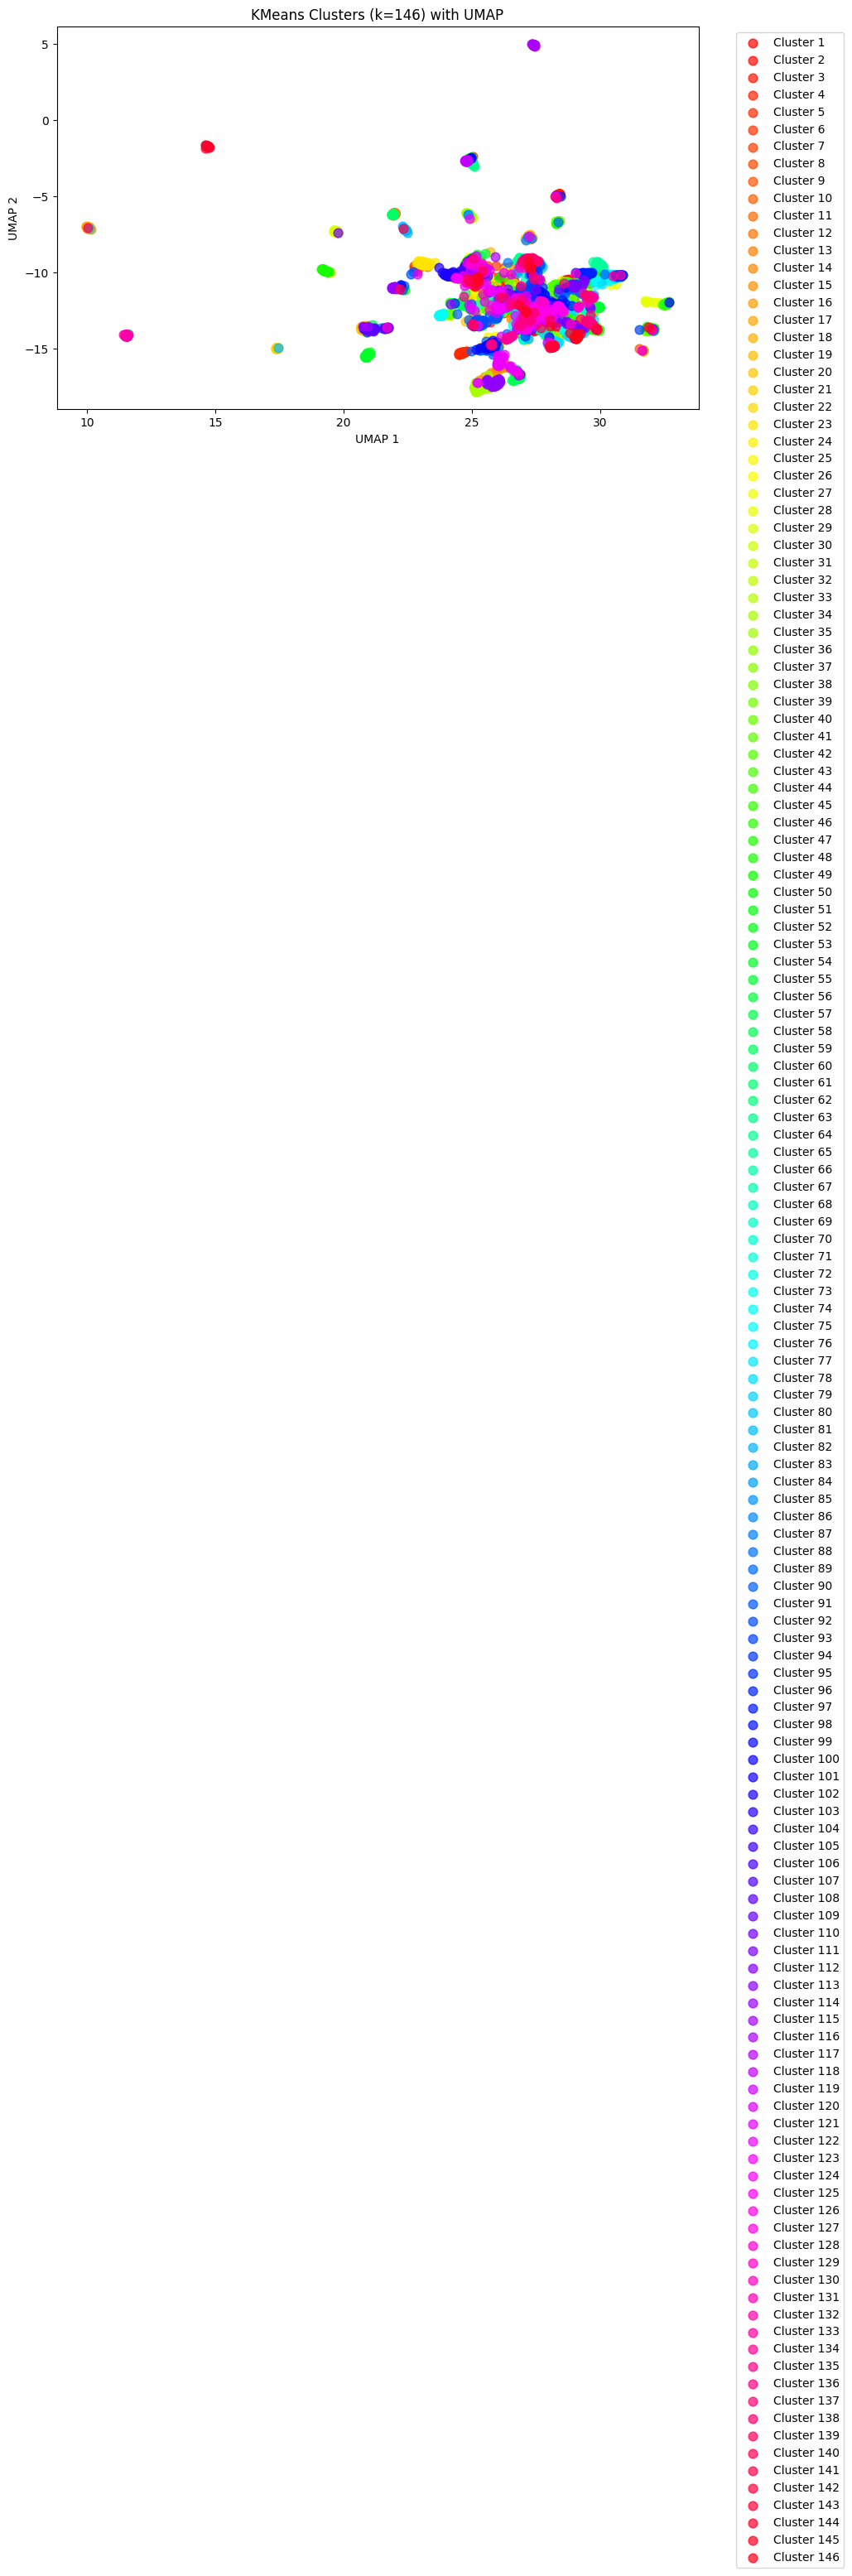

In [60]:
plt.figure(figsize=(10, 6))

cmap = plt.cm.get_cmap('hsv', n_clusters)

for i in range(n_clusters):
    mask = y_kmeans == i

    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        s=60,
        alpha=0.7,
        color=cmap(i),
        label=f'Cluster {i + 1}'
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'KMeans Clusters (k={n_clusters}) with UMAP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KMeans is not suitable for this project because it assumes clusters are spherical and of similar size, and it relies on minimizing variance around cluster centers. Our data likely has irregularly shaped clusters with varying densities, which KMeans cannot capture accurately. Methods like HDBSCAN are better for detecting non-uniform, dense regions, giving a more realistic clustering.

# **Hierarchical (Agglomerative Clustering)**

**Agglomerative (hierarchical) clustering** builds clusters by repeatedly **merging** the two most similar groups, starting with each person as its own cluster. This creates a **hierarchy** (a tree) of merges. To obtain the final labels, we **cut the hierarchy** at a chosen level to get `n_clusters = K`.

The definition of “most similar” depends on the chosen **parameter**:
- **Ward**: merges that minimize the increase of within-cluster variance (often works well for compact, spherical-ish groups)
- **Complete / Average**: merges based on the farthest / average distance between points across clusters (can produce different shapes)

### **Why hierarchical clustering is useful for our project**
We include it because it often produces **interpretable groupings** and offers an extra “explanation layer” through the hierarchy:

- **Interpretability through structure:** the hierarchy helps us understand how smaller profiles merge into broader profiles.
- **Flexible cluster shapes (depending on parameter):** it is not limited to the same assumptions as K-Means, so it can capture different structure in the needs space.
- **No random initialization:** results are typically more deterministic than K-Means/GMM (given the same metric/parameter), which can help reproducibility.

### **Limitations (important for interpretation)**
- We still need to choose **how many clusters** to extract (or where to cut the tree).
- It can become slow or memory-heavy if the dataset is large (especially without connectivity constraints).
- The choice of **metric + parameter** strongly affects results, so we will compare a small set (e.g., Ward vs Average/Complete) rather than everything.


In [28]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
dfhierarchical = train_df

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [29]:
for k in [2, 4, 6, 8, 10, 20, 30, 34]:
    labels = AgglomerativeClustering(k, linkage='ward').fit_predict(X_scaled)
    print(
        k,
        calinski_harabasz_score(X_scaled, labels),
        davies_bouldin_score(X_scaled, labels)
    )

2 123.25273675350167 6.537302286522032
4 107.41537762617816 4.562735549722992
6 98.43470981028098 4.451614829403785
8 92.26128033798673 4.270622167134017
10 87.37722236199562 3.9447747016436
20 67.7206750912158 3.778139119521454
30 58.06304863937499 3.600231652557781
34 55.447887833584645 3.4608933873132814


In [30]:
best_k = 4

Lower k values (like 2–4) give higher Calinski–Harabasz scores and higher Davies–Bouldin scores, but they are too coarse for a dataset with 389 features, capturing only broad structures.

In [31]:
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward'
)

hierarchical_labels = hierarchical.fit_predict(X_scaled)

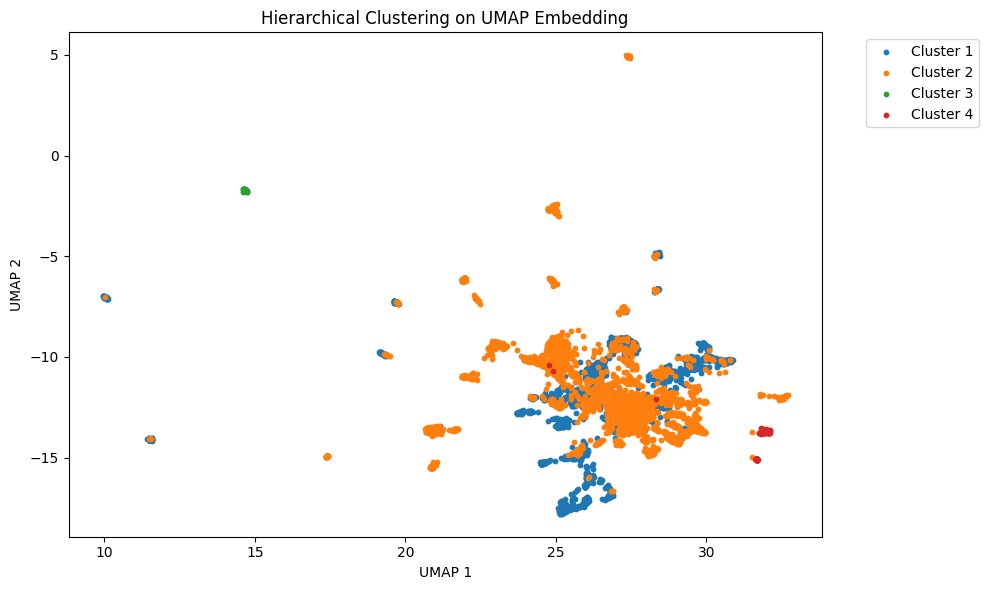

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Colormap
n_clusters = len(np.unique(hierarchical_labels))
cmap = plt.cm.get_cmap('tab20', n_clusters)

for i in range(n_clusters):
    mask = hierarchical_labels == i
    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        s=10,
        label=f'Cluster {i + 1}'
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("Hierarchical Clustering on UMAP Embedding")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Although the clustering evaluation indicates that 4 clusters provide the best statistical separation, this result mainly captures the global structure of the data and is too coarse for the objectives of this project. 

Our goal is to identify more detailed population groups in order to better support the selection and design of suitable shelters. 

Therefore, we will explore and compare different clustering models to determine whether alternative approaches can provide more useful and actionable groupings for this purpose.

# **DBSCAN**

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) groups points by identifying **dense regions** in the feature space. It defines clusters as areas where a point has at least `min_samples` neighbors within a radius `eps`. It naturally classifies points into:
- **Core points** (inside dense regions),
- **Border points** (near dense regions),
- **Noise** (outliers, labeled as `-1`).

DBSCAN does **not** require selecting the number of clusters in advance.

### **Why DBSCAN is useful for our project**
DBSCAN can be valuable when we expect:
- **Outliers / unusual cases:** people whose needs don’t match any common profile can be flagged as **noise**, which can be informative for workers.
- **Non-spherical groups:** it can discover clusters with shapes that K-Means/GMM may struggle with.

### **Limitations (important for interpretation)**
- It is sensitive to `eps`: small changes can drastically change the number of clusters and the noise ratio.
- It struggles when clusters have **different densities** (one dense group + one sparse group), which is common in real-world data.
- In high-dimensional feature spaces, distance neighborhoods become less informative; DBSCAN may label too many points as noise unless carefully tuned.

In [33]:
dfdbscan = train_df

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

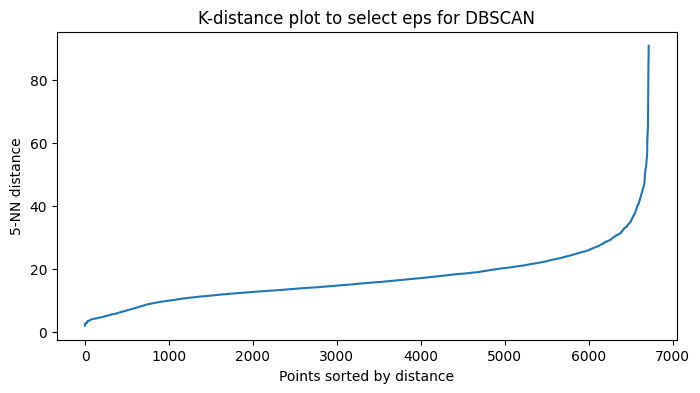

In [34]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("K-distance plot to select eps for DBSCAN")
plt.show()

The K-distance curve says that the best eps for this model (the elbow) is between 6 and 9.

In [69]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(
    eps=7,
    min_samples=5
)

labels = dbscan_model.fit_predict(X_scaled)

In [70]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(X_scaled, labels)
print("DBI:", dbi)

DBI: 1.8200144529983504


The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.

This 1.8 value is relativelly low. If we increase ther parameter eps, we get a bigger DBI. So this is a good approach for our model.

In [71]:
final_dbscan = DBSCAN(eps=7, min_samples=5)
final_labels = final_dbscan.fit_predict(X_scaled)

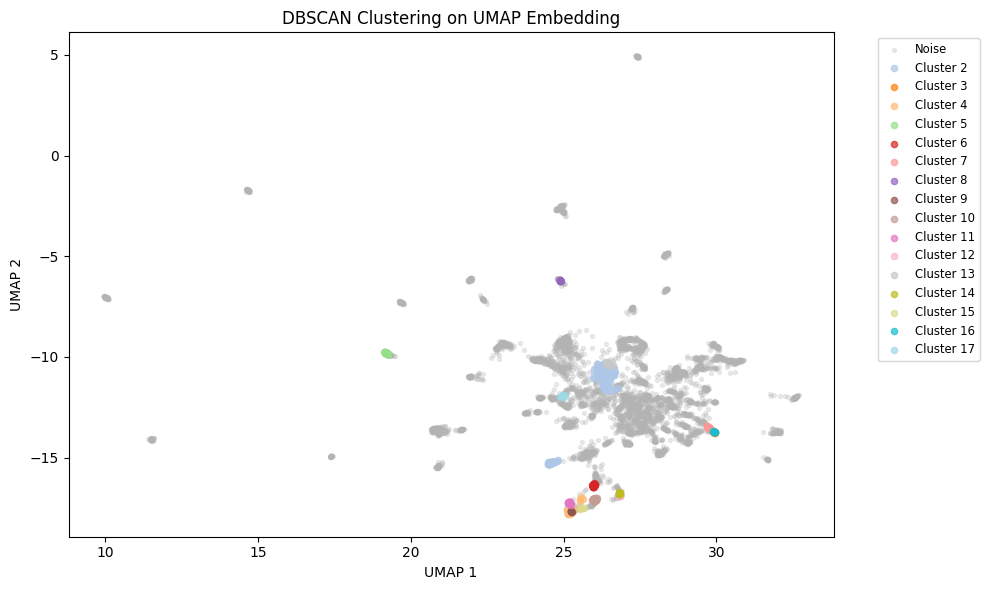

In [72]:
import matplotlib.pyplot as plt

cluster_ids = np.unique(final_labels)
cmap = plt.cm.get_cmap('tab20', len(cluster_ids))

plt.figure(figsize=(10, 6))
for idx, c in enumerate(cluster_ids):
    mask = final_labels == c
    color = (0.7, 0.7, 0.7) if c == -1 else cmap(idx)
    alpha = 0.25 if c == -1 else 0.7
    s = 8 if c == -1 else 20
    label = 'Noise' if c == -1 else f'Cluster {idx+1}'

    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        color=color,
        alpha=alpha,
        s=s,
        label=label
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("DBSCAN Clustering on UMAP Embedding")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

The current DBSCAN configuration is appropriate because the eps parameter was selected using the k-distance plot, which means it reflects the true density structure of the data rather than being chosen arbitrarily. The resulting clusters are well separated in the UMAP space, and most low-density or anomalous points are correctly identified as noise. In addition, the Davies–Bouldin index is significantly improved, indicating that the clusters are compact and well differentiated.

Overall, this shows that DBSCAN is capturing the natural grouping of the data reasonably well.

However, we will also experiment with HDBSCAN, which is a more advanced density-based clustering method. Unlike DBSCAN, HDBSCAN can automatically adapt to clusters with varying densities and does not rely on a single fixed eps value. It generally produces more stable and robust clusters on UMAP embeddings, and often yields more natural and reliable segmentation results.

# **HDBSCAN**

**HDBSCAN** extends DBSCAN by building a **hierarchy of density-based clusters** and then selecting the most stable clusters across density levels. This makes it generally more robust than DBSCAN when cluster densities vary. Like DBSCAN, it can label points as **noise** (`-1`) and does not require a fixed number of clusters.

Key concepts:
- It explores many density thresholds automatically (instead of a single `eps`).
- It prefers clusters that are **stable/persistent** across thresholds.

### **Why HDBSCAN is useful for our project**
HDBSCAN is often a strong choice for real-world “needs” data because:
- **Handles variable density better:** different “problem profiles” may appear at different frequencies and densities.
- **Outlier-aware:** noise points can represent atypical or mixed cases that deserve special attention.
- **Useful cluster stability signal:** stability aligns well with our goal of finding reliable, meaningful groupings (not just a lucky partition).

### **Limitations (important for interpretation)**
- It can produce a **high noise ratio** if parameters are too strict or the data has weak density structure.
- Cluster counts can change significantly with `min_cluster_size` / `min_samples`, so we must tune with care and track stability + usability constraints.
- Like DBSCAN, it can be impacted by high-dimensional distance issues; results must be validated with interpretability and stability checks.

In [39]:
import hdbscan

In [40]:
dfhdbscan = train_df

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

### Optimal configuration
Lets search whats the optimal configuration for our HDBSCAN model now

In [42]:
from itertools import product
from sklearn.metrics import silhouette_score
import hdbscan
import pandas as pd
import numpy as np

param_grid = {
    'min_cluster_size': [15, 20, 25, 30],
    'min_samples': [6, 7, 8, 9, 10, 20, 30]
}

results = []

for mcs, ms in product(param_grid['min_cluster_size'], param_grid['min_samples']):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
    labels = clusterer.fit_predict(X_scaled)
    
    mask = labels != -1
    unique_labels = np.unique(labels[mask])
    if unique_labels.size < 2:
        continue
    
    score = silhouette_score(X_scaled[mask], labels[mask])
    results.append({'min_cluster_size': mcs, 'min_samples': ms, 'silhouette': score})

results_df = pd.DataFrame(results)
if results_df.empty:
    print("No valid clustering found (need >=2 clusters excluding noise).")
    best_min_cluster_size = param_grid['min_cluster_size'][0]
    best_min_samples = param_grid['min_samples'][0]
else:
    results_df = results_df.sort_values('silhouette', ascending=False)
    print(results_df)
    best_min_cluster_size = int(results_df.iloc[0]['min_cluster_size'])
    best_min_samples = int(results_df.iloc[0]['min_samples'])

    min_cluster_size  min_samples  silhouette
26                30           20    0.365422
12                20           20    0.364987
19                25           20    0.364865
16                25            8    0.358214
15                25            7    0.356935
14                25            6    0.355998
21                30            6    0.355998
17                25            9    0.354414
18                25           10    0.352702
5                 15           20    0.350768
4                 15           10    0.319727
25                30           10    0.317779
3                 15            9    0.314725
11                20           10    0.312350
24                30            9    0.310088
10                20            9    0.307988
20                25           30    0.307675
27                30           30    0.307675
6                 15           30    0.307675
13                20           30    0.307675
23                30            8 

Best params are pulled from the grid search above (stored in `best_min_cluster_size` / `best_min_samples`).

In [100]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=20)
labels = clusterer.fit_predict(X_scaled)

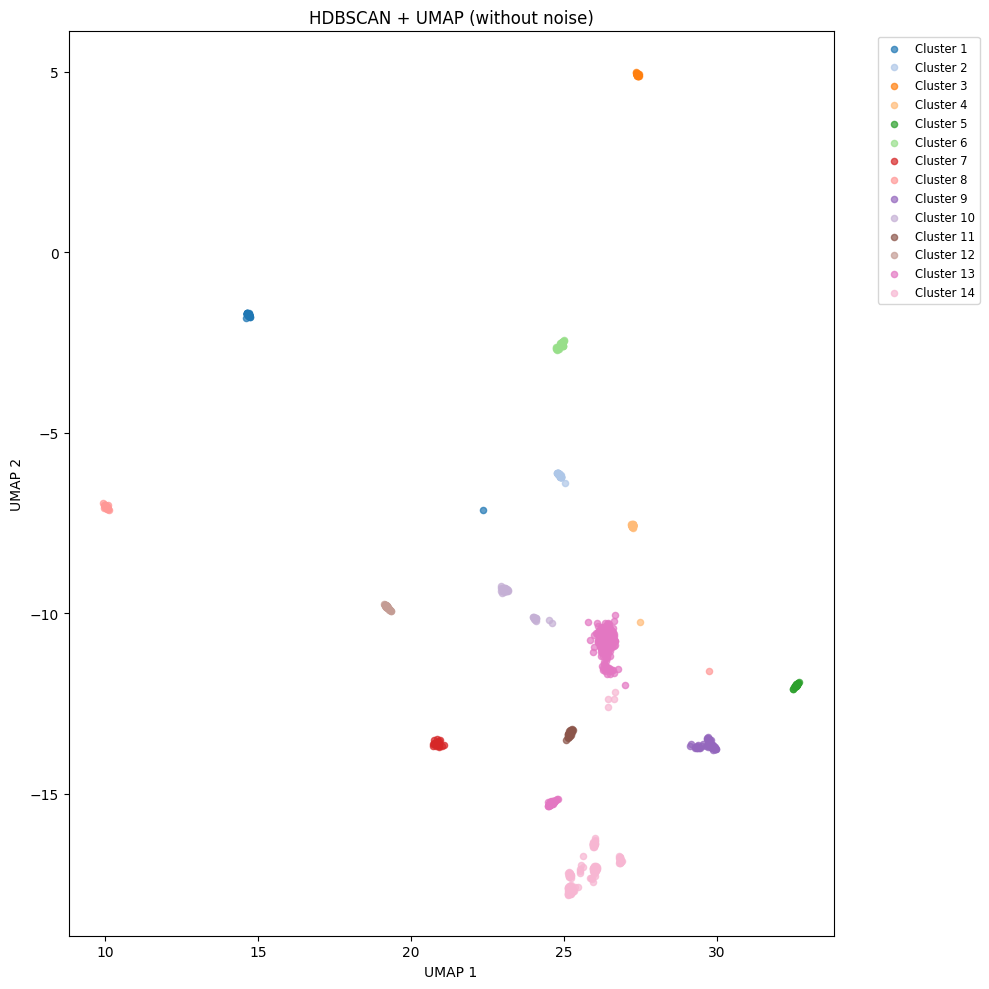

In [101]:
dfhdbscan['cluster'] = labels
plt.figure(figsize=(10, 10))

show_noise = False

cluster_ids = [c for c in np.unique(dfhdbscan['cluster']) if (c != -1 or show_noise)]

if show_noise and (-1 in np.unique(dfhdbscan['cluster'])):
    cluster_ids = sorted(np.unique(dfhdbscan['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(dfhdbscan['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No clusters found.")
else:
    cmap = plt.cm.get_cmap('tab20')
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = dfhdbscan['cluster'] == orig_cluster
        if orig_cluster == -1:
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(dfhdbscan.loc[mask, 'umap1'], dfhdbscan.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('HDBSCAN + UMAP (without noise)' if not show_noise else 'cluster' + 'HDBSCAN + UMAP (with noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=30, random_state=0).fit_transform(X_scaled)
labels = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5).fit_predict(X_pca)

In [ ]:
import hdbscan
import numpy as np
import pandas as pd

param_grid = {
    "min_cluster_size": [30],
    "min_samples": [5]   # None = defaults to min_cluster_size
}

rows = []

for mcs in param_grid["min_cluster_size"]:
    for ms in param_grid["min_samples"]:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            prediction_data=False
        )
        labels = clusterer.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue

        noise_ratio = np.mean(labels == -1)

        non_noise = labels != -1
        mean_conf = float(np.mean(clusterer.probabilities_[non_noise])) if np.any(non_noise) else 0.0
        mean_persist = float(np.mean(clusterer.cluster_persistence_)) if len(clusterer.cluster_persistence_) else 0.0

        # cluster size stats
        sizes = np.bincount(labels[non_noise])
        # careful: bincount uses label ids; easiest is:
        uniq, cnt = np.unique(labels[non_noise], return_counts=True)
        min_size = int(cnt.min())
        med_size = float(np.median(cnt))

        rows.append({
            "mcs": mcs,
            "ms": ms,
            "n_clusters": n_clusters,
            "noise": noise_ratio,
            "mean_conf": mean_conf,
            "mean_persistence": mean_persist,
            "min_cluster_size_found": min_size,
            "median_cluster_size": med_size
        })

df = pd.DataFrame(rows)

print("Total valid runs (>=2 clusters):", len(df))
print(df.sort_values(["noise","n_clusters"]).head(20))
print(df.describe(include="all"))

# Example filtering rules (tune these to your expectations)
df2 = df[
    (df["noise"].between(0.05, 0.45)) &      # not too little / too much noise
    (df["min_cluster_size_found"] >= 10) &   # avoid tiny clusters
    (df["n_clusters"].between(3, 30))        # avoid 1-2 clusters or 200 clusters
].copy()

# Rank: prefer stability + confidence, then reasonable noise
df2["score"] = (
    0.45 * df2["mean_persistence"] +
    0.45 * df2["mean_conf"] -
    0.10 * df2["noise"]
)

df2 = df2.sort_values("score", ascending=False)
print(df2.head(15))

Total valid runs (>=2 clusters): 1
   mcs  ms  n_clusters     noise  mean_conf  mean_persistence  \
0   30   5           2  0.097812   0.989848          0.017527   

   min_cluster_size_found  median_cluster_size  
0                      32               3030.0  
        mcs   ms  n_clusters     noise  mean_conf  mean_persistence  \
count   1.0  1.0         1.0  1.000000   1.000000          1.000000   
mean   30.0  5.0         2.0  0.097812   0.989848          0.017527   
std     NaN  NaN         NaN       NaN        NaN               NaN   
min    30.0  5.0         2.0  0.097812   0.989848          0.017527   
25%    30.0  5.0         2.0  0.097812   0.989848          0.017527   
50%    30.0  5.0         2.0  0.097812   0.989848          0.017527   
75%    30.0  5.0         2.0  0.097812   0.989848          0.017527   
max    30.0  5.0         2.0  0.097812   0.989848          0.017527   

       min_cluster_size_found  median_cluster_size  
count                     1.0              

In [ ]:
import hdbscan
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# --- PCA to 50 dimensions (clustering space) ---
pca = PCA(n_components=50, random_state=0)
X_pca50 = pca.fit_transform(X_scaled)

print("X_scaled shape:", X_scaled.shape)
print("X_pca50 shape:", X_pca50.shape)
print("Explained variance (50 comps):", pca.explained_variance_ratio_.sum())

param_grid = {
    "min_cluster_size": [2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 10],
    "min_samples": [2, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]   # None = defaults to min_cluster_size (HDBSCAN default behavior)
}

rows = []

for mcs in param_grid["min_cluster_size"]:
    for ms in param_grid["min_samples"]:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            prediction_data=False
        )
        labels = clusterer.fit_predict(X_pca50)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue

        noise_ratio = np.mean(labels == -1)

        non_noise = labels != -1
        mean_conf = float(np.mean(clusterer.probabilities_[non_noise])) if np.any(non_noise) else 0.0
        mean_persist = float(np.mean(clusterer.cluster_persistence_)) if len(clusterer.cluster_persistence_) else 0.0

        # cluster size stats (exclude noise)
        uniq, cnt = np.unique(labels[non_noise], return_counts=True)
        min_size = int(cnt.min())
        med_size = float(np.median(cnt))

        rows.append({
            "mcs": mcs,
            "ms": ms,
            "n_clusters": n_clusters,
            "noise": noise_ratio,
            "mean_conf": mean_conf,
            "mean_persistence": mean_persist,
            "min_cluster_size_found": min_size,
            "median_cluster_size": med_size
        })

df = pd.DataFrame(rows)

print("Total valid runs (>=2 clusters):", len(df))
if not df.empty:
    print(df.sort_values(["noise", "n_clusters"]).head(20))
    print(df.describe(include="all"))
else:
    print("No valid clusterings found (>=2 clusters excluding noise).")

# Example filtering rules (tune these to your expectations)
if not df.empty:
    df2 = df[
        (df["noise"].between(0.30, 0.70)) &
        (df["n_clusters"].between(10, 40)) &
        (df["min_cluster_size_found"] >= 20)
    ].copy()

    if df2.empty:
        print("\nNo configs passed the filter. Try relaxing thresholds (noise/n_clusters/min_cluster_size_found).")
    else:
        # Rank: prefer stability + confidence, then reasonable noise
        df2["score"] = (
            0.50 * df2["mean_persistence"] +
            0.40 * df2["mean_conf"] -
            0.30 * df2["noise"]
        )

        df2 = df2.sort_values("score", ascending=False)
        print(df2.head(15))


X_scaled shape: (6717, 500)
X_pca50 shape: (6717, 50)
Explained variance (50 comps): 0.4248345553967885
Total valid runs (>=2 clusters): 156
     mcs    ms  n_clusters     noise  mean_conf  mean_persistence  \
108   70   NaN           2  0.198749   0.882760          0.039928   
143   90  20.0           2  0.201280   0.922165          0.026164   
13     4   2.0         219  0.362215   0.937808          0.020802   
0      2   NaN         390  0.363555   0.949271          0.012460   
1      2   2.0         390  0.363555   0.949271          0.012460   
25     8   2.0         118  0.364002   0.925224          0.021682   
37    10   2.0         103  0.386482   0.920918          0.025735   
145   10   2.0         103  0.386482   0.920918          0.025735   
49    20   2.0          61  0.419681   0.915095          0.057459   
2      2   4.0         185  0.422063   0.929370          0.014256   
12     4   NaN         136  0.427721   0.910088          0.019031   
14     4   4.0         136  0.4

We selected **HDBSCAN with** `min_cluster_size = 30` **and** `min_samples = 5` because it provides the best practical trade-off for our project goals. With these settings, the model produces **a manageable number of clusters** (on the order of a few dozen rather than hundreds), which makes the resulting groups **interpretable and usable** as “user profiles” in a downstream recommendation or matching step.

This configuration also shows **relatively strong cluster stability** (higher average persistence compared to most alternatives) and **high membership confidence** for the points that are assigned to clusters. In other words, the clusters that HDBSCAN identifies at these parameters tend to be consistent and well-defined, rather than fragile micro-clusters that change easily with small parameter adjustments.

Although the noise fraction remains non-trivial, we consider this acceptable for our use case: HDBSCAN is intentionally conservative, and labeling ambiguous or low-density points as noise is preferable to forcing unreliable assignments. This supports a realistic interpretation where the clustered points represent **clear, recurring profiles**, while the noise corresponds to **atypical or mixed cases** that may require different handling.

In [93]:
best_mcs = 30
best_ms = 5

clusterer = hdbscan.HDBSCAN(min_cluster_size=best_mcs, min_samples=best_ms)
labels = clusterer.fit_predict(X_pca50)

In [94]:
print("best mcs: " + str(best['mcs']))
print("best ms: " + str(best['ms']))

best mcs: 40.0
best ms: 2.0


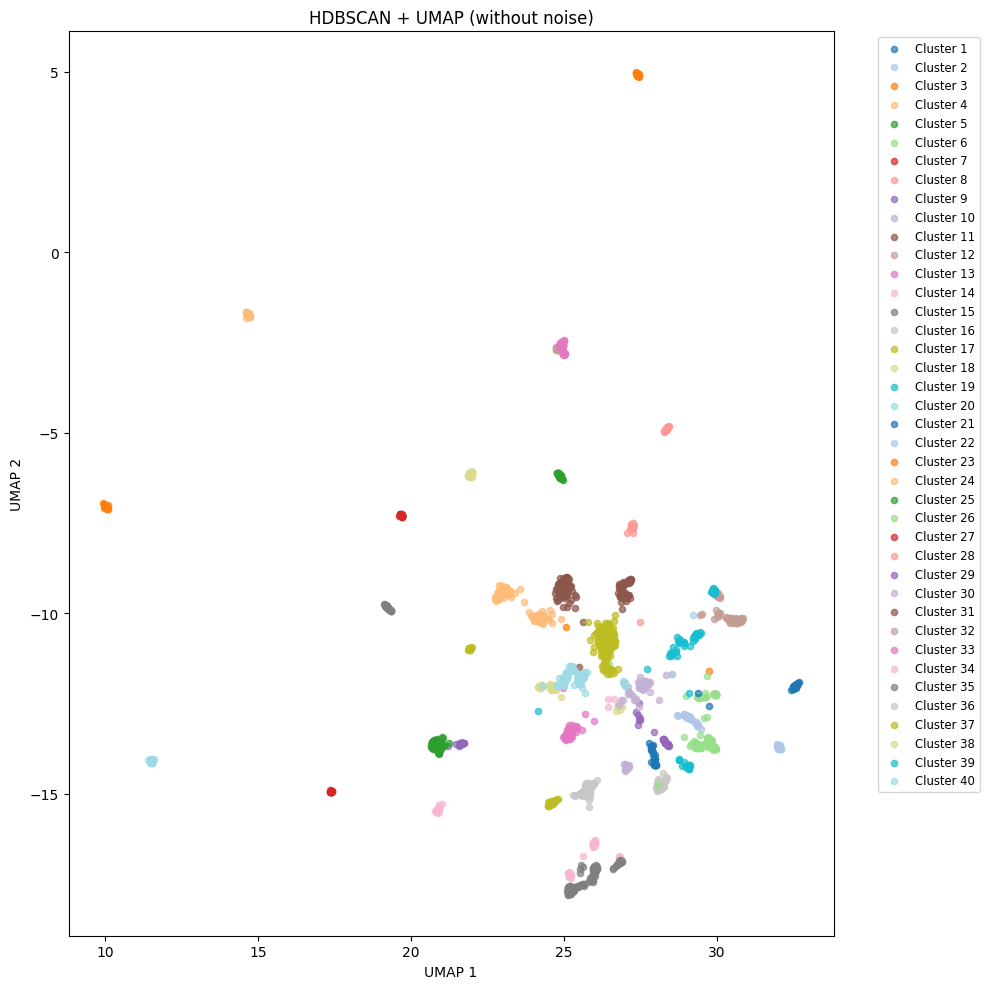

In [91]:
dfhdbscan['cluster'] = labels
plt.figure(figsize=(10, 10))

show_noise = False

cluster_ids = [c for c in np.unique(dfhdbscan['cluster']) if (c != -1 or show_noise)]

if show_noise and (-1 in np.unique(dfhdbscan['cluster'])):
    cluster_ids = sorted(np.unique(dfhdbscan['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(dfhdbscan['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No clusters found.")
else:
    cmap = plt.cm.get_cmap('tab20')
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = dfhdbscan['cluster'] == orig_cluster
        if orig_cluster == -1:
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(dfhdbscan.loc[mask, 'umap1'], dfhdbscan.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('HDBSCAN + UMAP (without noise)' if not show_noise else 'cluster' + 'HDBSCAN + UMAP (with noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

# **GMM (Gaussian Mixture Models)**

A **Gaussian Mixture Model (GMM)** assumes the data is generated from a mixture of several Gaussian distributions (components). Unlike K-Means, which assigns each point to exactly one cluster, GMM provides **soft assignments**: each person gets a probability of belonging to each component.

We must choose `n_components` (similar to choosing K), and the model learns:
- component means,
- covariances (shape/spread),
- and mixing weights (how frequent each component is).

### **Why GMM is useful for our project**
GMM is useful because it gives extra information beyond hard labels:

- **Uncertainty awareness:** if a person has similar probabilities for multiple clusters, we can flag the case as “mixed/uncertain”, which is helpful for decision support.
- **More flexible cluster geometry than K-Means:** components can model different spreads (depending on covariance type), which may better fit real need distributions.
- **Probabilistic interpretation:** supports “this person is 70% profile A, 30% profile B” style outputs when needed.

### **Limitations (important for interpretation)**
- It still requires choosing the number of components; we will typically use **AIC/BIC curves** + our evaluation framework to select candidates.
- With many features, full covariance can be heavy or unstable; we may need simpler covariance types (e.g., diagonal) for reliability.
- Like K-Means, it can converge to local optima, so multiple initializations may be needed for stable results.

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.